Programming Assignment 2:
A Sentiment Analysis

Implementation/Development code

In [ ]:
# Install necessary libraries
!pip install gensim --upgrade  # Install or upgrade the Gensim library for word embeddings
!pip install keras --upgrade  # Install or upgrade Keras for deep learning
!pip install pandas --upgrade  # Install or upgrade Pandas for data manipulation

# Import libraries
import pandas as pd  # Import Pandas for data handling
import matplotlib.pyplot as plt  # Import Matplotlib for plotting
import numpy as np  # Import NumPy for numerical operations
import os  # Import OS for operating system functionality
import re  # Import Regular Expressions for text processing
import time  # Import Time for timing operations
import pickle  # Import Pickle for saving models
import logging  # Import logging for logging messages
import itertools  # Import itertools for creating iterators
from collections import Counter  # Import Counter for counting hashable objects

# NLTK
import nltk  # Import Natural Language Toolkit for NLP tasks
from nltk.corpus import stopwords  # Import stopwords to remove common words
from nltk.stem import SnowballStemmer  # Import SnowballStemmer for stemming words

# Word2Vec
import gensim  # Import Gensim for word vectorization

# Keras
from tensorflow.keras.preprocessing.text import Tokenizer  # Import Tokenizer from tensorflow.keras
from keras.preprocessing.sequence import pad_sequences  # Import pad_sequences to ensure uniform input size
from keras.models import Sequential  # Import Sequential model for building neural networks
from keras.layers import Activation, Dense, Dropout, Embedding, LSTM  # Import layers for the model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping  # Import callbacks for training optimization

# Scikit-learn
from sklearn.model_selection import train_test_split  # Import function to split dataset into training and testing
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder for encoding labels
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score  # Import evaluation metrics

# Configure logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)  # Set up logging format and level
nltk.download('stopwords')  # Download stopwords from NLTK

# Constants
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]  # Define dataset columns
DATASET_ENCODING = "ISO-8859-1"  # Set encoding for the dataset
TRAIN_SIZE = 0.8  # Define training size proportion
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"  # Regex pattern for cleaning text
POSITIVE, NEUTRAL, NEGATIVE = "POSITIVE", "NEUTRAL", "NEGATIVE"  # Define sentiment labels
SENTIMENT_THRESHOLDS = (0.4, 0.7)  # Define thresholds for sentiment classification

# Word2Vec model parameters
W2V_SIZE, W2V_WINDOW, W2V_EPOCH, W2V_MIN_COUNT = 300, 7, 32, 10  # Define parameters for Word2Vec

# Keras model parameters
SEQUENCE_LENGTH, EPOCHS, BATCH_SIZE = 300, 8, 1024  # Define parameters for Keras model

# Model files
KERAS_MODEL, WORD2VEC_MODEL = "sentimentanalysis.h5", "sentimentanalysis.w2v"
TOKENIZER_MODEL, ENCODER_MODEL = "sentimentanalysis_tokenizer.pkl", "sentimentanalysis_encoder.pkl"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 41.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.6.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Load dataset
# Assuming the dataset is downloaded and unzipped
dataset_filename = "training.1600000.processed.noemoticon.csv"  # Specify the CSV file name
dataset_path = os.path.join(".", dataset_filename)  # # Construct the full path to the dataset
df = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=DATASET_COLUMNS)  # Load dataset into a DataFrame

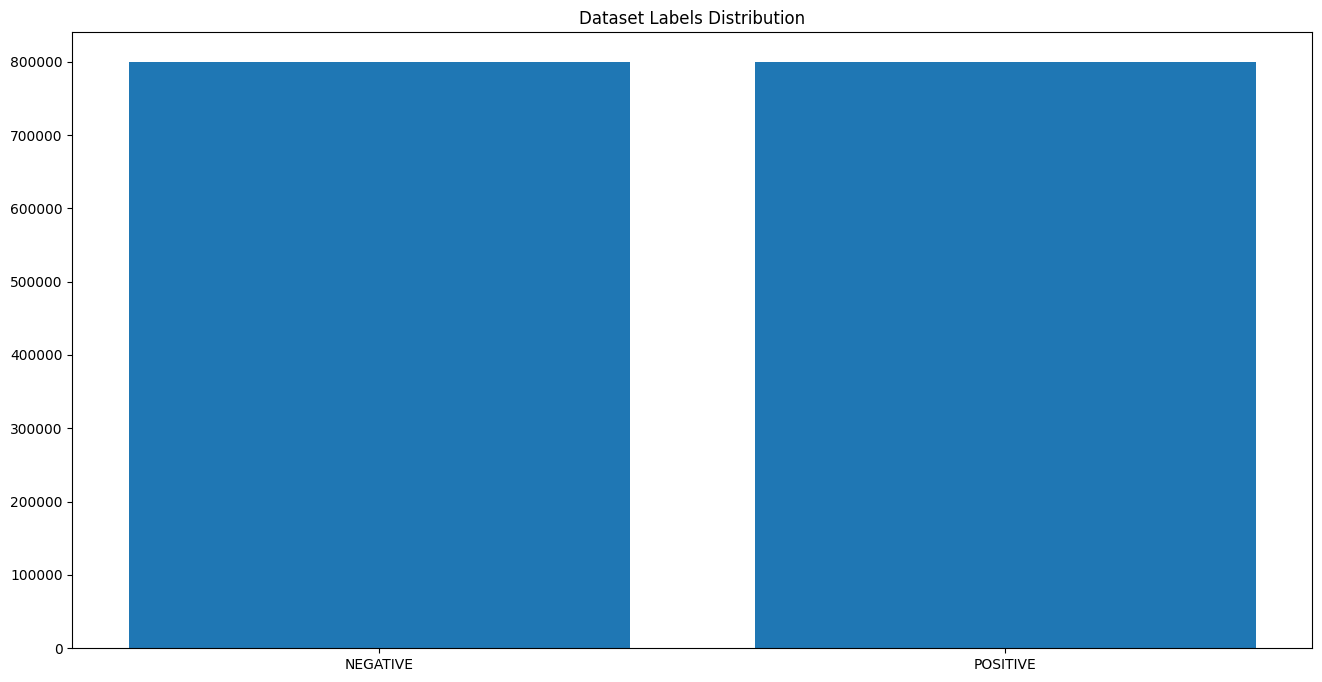

In [ ]:
# Decode sentiment labels
decode_map = {0: NEGATIVE, 2: NEUTRAL, 4: POSITIVE}  # Mapping from numerical labels to sentiment labels
df.target = df.target.apply(lambda x: decode_map[int(x)])  # Decode labels using the mapping

# Visualize label distribution
target_cnt = Counter(df.target)  # Count occurrences of each sentiment label
plt.figure(figsize=(16, 8))  # Set the figure size for the bar plot
plt.bar(target_cnt.keys(), target_cnt.values())  # Create a bar plot of the label distribution
plt.title("Dataset Labels Distribution")  # Set title for the plot
plt.show()  # Show the plot

In [ ]:
# Text preprocessing
stop_words = stopwords.words("english")  # Get a list of English stopwords
stemmer = SnowballStemmer("english")  # Initialize the Snowball stemmer for English

def preprocess(text, stem=False):
    # Function to preprocess text: remove unwanted characters and stem if required
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()  # Clean text using regex
    # Tokenize and remove stopwords; stem if specified
    tokens = [stemmer.stem(token) if stem else token for token in text.split() if token not in stop_words]
    return " ".join(tokens)  # Join tokens back into a string

# Apply preprocessing to the text column
df.text = df.text.apply(lambda x: preprocess(x))  # Preprocess each text sample in the DataFrame

# Split the dataset into training and testing sets
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)  # Split with a defined random state

# Word2Vec model
documents = [_text.split() for _text in df_train.text]  # Split the training text into documents (list of tokens)
w2v_model = gensim.models.Word2Vec(vector_size=W2V_SIZE, window=W2V_WINDOW,
                                   min_count=W2V_MIN_COUNT, workers=8)  # Initialize the Word2Vec model
w2v_model.build_vocab(documents)  # Build the vocabulary based on training documents
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)  # Train the Word2Vec model

# Tokenization
tokenizer = Tokenizer()  # Initialize the Keras Tokenizer
tokenizer.fit_on_texts(df_train.text)  # Fit the tokenizer on the training text

vocab_size = len(tokenizer.word_index) + 1  # Get the vocabulary size (number of unique tokens)
# Pad sequences to ensure uniform input size for LSTM
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)  # Pad training sequences
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)  # Pad testing sequences

# Label Encoding
encoder = LabelEncoder()  # Initialize the LabelEncoder
encoder.fit(df_train.target.tolist())  # Fit the encoder on the training labels

# Transform labels to numerical format
y_train = encoder.transform(df_train.target.tolist()).reshape(-1, 1)  # Encode and reshape training labels
y_test = encoder.transform(df_test.target.tolist()).reshape(-1, 1)  # Encode and reshape testing labels

# Embedding matrix
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))  # Initialize the embedding matrix
for word, i in tokenizer.word_index.items():  # Iterate through words in the tokenizer's word index
    if word in w2v_model.wv:  # Check if the word is in the Word2Vec model
        embedding_matrix[i] = w2v_model.wv[word]  # Populate the embedding matrix with Word2Vec embeddings


In [ ]:
# Deep Learning LSTM Model
# Create the embedding layer using the embedding matrix
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix],
                            input_length=SEQUENCE_LENGTH, trainable=False)# Trainable=False

# Build the LSTM model
model = Sequential([
    embedding_layer,  # Add embedding layer
    Dropout(0.5),  # Add dropout layer to prevent overfitting
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),  # Add LSTM layer with dropout
    Dense(1, activation='sigmoid')  # Add output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  # Define loss and optimizer
model.summary()  # Print model summary

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      87,125,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,125,700 (332.36 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 87,125,700 (332.36 MB)

# Deep Learning LSTM Model(Build)



**Embedding Layer**

*vocab_size:*


*   Total number of unique words (tokens) in the vocabulary plus one (for padding).
*   This defines the input dimension of the embedding matrix.

*W2V_SIZE:*


*   The size of each word vector (embedding dimension). For example, if W2V_SIZE = 300, word is represented by a 300-dimensional vector.

*weights=[embedding_matrix]:*



*   Pre-trained embedding matrix (such as Word2Vec) containing word vectors for each word in the vocabulary.
*   The weights are initialized using these pre-trained vectors instead of random values.

*input_length=SEQUENCE_LENGTH:*


*   The length of input sequences (e.g., if SEQUENCE_LENGTH = 300, each input text will be truncated or padded to 300 tokens).



*trainable=False:*


*   If set to False, the embedding weights are frozen and will not be updated during training
*   This saves computational resources and preserves the quality of pre-trained embeddings

**Dropout Layer:**



*   The dropout rate. This means 50% of the neurons will be randomly deactivated (set to 0) during each training iteration to prevent overfitting.


**LSTM Layer:**

*100:*


*   The number of units/neurons in the LSTM layer. Each unit captures dependencies from the input sequence over time.


*dropout=0.2:*



*   Dropout rate applied to the input-to-hidden connections (20% of the input neurons will be dropped during training).


*recurrent_dropout=0.2:*



*   Dropout rate applied to the recurrent connections (between the hidden states across timesteps). It helps prevent overfitting by deactivating some connections within the LSTM layer


**Dense Layer:**

*1:*



*   This is the output size. Since this is a binary classification task (positive or negative sentiment), the output is a single neuron


*activation='sigmoid':*



*   The sigmoid activation function ensures that the output is between 0 and 1, which can be interpreted as the probability of belonging to the positive class



















In [ ]:
# Model Training
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5),  # Reduce learning rate when validation loss plateaus
             EarlyStopping(monitor='val_accuracy', patience=5, min_delta=1e-4)]  # Stop training early if no improvement

# Fit the model on training data
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_split=0.1, verbose=1, callbacks=callbacks)

Epoch 1/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 293s 257ms/step - accuracy: 0.7300 - loss: 0.5298 - val_accuracy: 0.7784 - val_loss: 0.4652 - learning_rate: 0.0010
Epoch 2/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 289s 257ms/step - accuracy: 0.7617 - loss: 0.4874 - val_accuracy: 0.7833 - val_loss: 0.4564 - learning_rate: 0.0010
Epoch 3/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 289s 257ms/step - accuracy: 0.7674 - loss: 0.4785 - val_accuracy: 0.7860 - val_loss: 0.4530 - learning_rate: 0.0010
Epoch 4/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 289s 257ms/step - accuracy: 0.7710 - loss: 0.4735 - val_accuracy: 0.7869 - val_loss: 0.4503 - learning_rate: 0.0010
Epoch 5/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 289s 257ms/step - accuracy: 0.7732 - loss: 0.4695 - val_accuracy: 0.7876 - val_loss: 0.4483 - learning_rate: 0.0010
Epoch 6/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 290s 258ms/step - accuracy: 0.7730 - loss: 0.4691 - val_accuracy: 0.7880 - val_loss: 0.4486 - learning_rate: 0.0010
Epoch 7/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 290s 257ms/step -

In [ ]:
# Import Logistic Regression from Scikit-Learn
from sklearn.linear_model import LogisticRegression

# Train and evaluate Logistic Regression
lr_model = LogisticRegression(max_iter=1000)  # Initialize Logistic Regression model with a maximum of 1000 iterations
lr_model.fit(x_train, y_train)  # Fit the model on the training data (features and labels)

y_pred = lr_model.predict(x_test)  # Make predictions on the test set
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))  # Calculate and print accuracy of predictions
print(classification_report(y_test, y_pred))  # Print detailed classification report including precision, recall, and F1 score

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.497759375
              precision    recall  f1-score   support

           0       0.45      0.03      0.06    159494
           1       0.50      0.96      0.66    160506

    accuracy                           0.50    320000
   macro avg       0.47      0.50      0.36    320000
weighted avg       0.47      0.50      0.36    320000



In [ ]:
# Import Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB

# Train and evaluate Naive Bayes
nb_model = MultinomialNB()  # Initialize Multinomial Naive Bayes model
nb_model.fit(x_train, y_train)  # Fit the model on the training data

y_pred = nb_model.predict(x_test)  # Make predictions on the test set
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred))  # Calculate and print accuracy of predictions
print(classification_report(y_test, y_pred))  # Print detailed classification report


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Naive Bayes Accuracy: 0.510165625
              precision    recall  f1-score   support

           0       0.52      0.26      0.34    159494
           1       0.51      0.76      0.61    160506

    accuracy                           0.51    320000
   macro avg       0.51      0.51      0.48    320000
weighted avg       0.51      0.51      0.48    320000



In [ ]:
# Import Support Vector Machine (SVM) from Scikit-Learn
from sklearn.svm import LinearSVC

# Train and evaluate SVM
svm_model = LinearSVC()  # Initialize Linear Support Vector Classifier model
svm_model.fit(x_train, y_train)  # Fit the model on the training data

y_pred = svm_model.predict(x_test)  # Make predictions on the test set
print("SVM Accuracy:", accuracy_score(y_test, y_pred))  # Calculate and print accuracy of predictions
print(classification_report(y_test, y_pred))  # Print detailed classification report


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Accuracy: 0.4989625
              precision    recall  f1-score   support

           0       0.46      0.03      0.06    159494
           1       0.50      0.96      0.66    160506

    accuracy                           0.50    320000
   macro avg       0.48      0.50      0.36    320000
weighted avg       0.48      0.50      0.36    320000



In [ ]:
# Import Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

# Train and evaluate Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # Initialize Random Forest model with 100 trees
rf_model.fit(x_train, y_train)  # Fit the model on the training data

y_pred = rf_model.predict(x_test)  # Make predictions on the test set
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))  # Calculate and print accuracy of predictions
print(classification_report(y_test, y_pred))  # Print detailed classification report

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Accuracy: 0.61578125
              precision    recall  f1-score   support

           0       0.60      0.68      0.64    159494
           1       0.63      0.55      0.59    160506

    accuracy                           0.62    320000
   macro avg       0.62      0.62      0.61    320000
weighted avg       0.62      0.62      0.61    320000



313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.7848 - loss: 0.4526
ACCURACY: 0.7848312258720398
LOSS: 0.4536217749118805


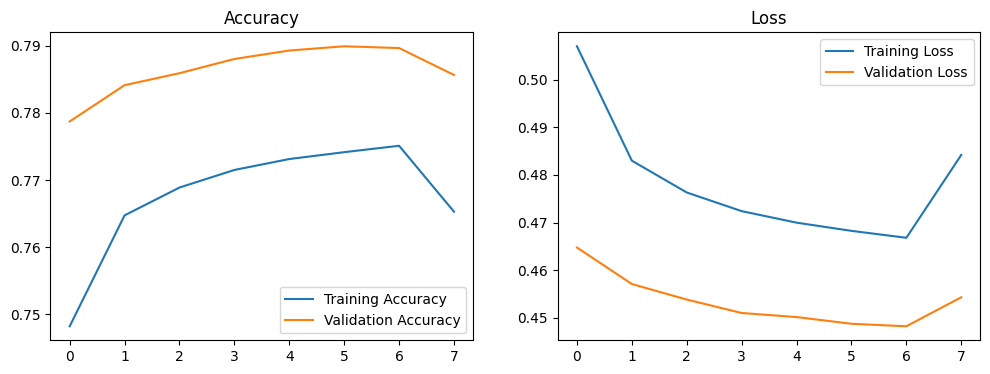

In [ ]:
# Evaluation LSTM
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)  # Evaluate the model on the test set
print(f"ACCURACY: {score[1]}\nLOSS: {score[0]}")  # Print accuracy and loss

# Plot training history
def plot_history(history):
    # Function to plot accuracy and loss over epochs
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']  # Get training and validation accuracy
    loss, val_loss = history.history['loss'], history.history['val_loss']  # Get training and validation loss

    plt.figure(figsize=(12, 4))  # Set figure size for subplots
    plt.subplot(1, 2, 1)  # First subplot for accuracy
    plt.plot(acc, label='Training Accuracy')  # Plot training accuracy
    plt.plot(val_acc, label='Validation Accuracy')  # Plot validation accuracy
    plt.legend()  # Show legend
    plt.title('Accuracy')  # Set title for accuracy plot

    plt.subplot(1, 2, 2)  # Second subplot for loss
    plt.plot(loss, label='Training Loss')  # Plot training loss
    plt.plot(val_loss, label='Validation Loss')  # Plot validation loss
    plt.legend()  # Show legend
    plt.title('Loss')  # Set title for loss plot

    plt.show()  # Show plots

plot_history(history)  # Call the function to plot training history

In [ ]:

# Save models
model.save(KERAS_MODEL) # Save the Keras model to an HDF5 file
w2v_model.save(WORD2VEC_MODEL) # Save the Word2Vec model
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"))  # Save the tokenizer to a pickle file
pickle.dump(encoder, open(ENCODER_MODEL, "wb")) # Save the label encoder to a pickle file

40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 545ms/step


Accuracy: 0.0


In [8]:
# Upload the model file “sentimentanalysis.h5”, tokenizer pickle file “sentimentanalysis_tokenizer.pkl” and
# encoder file “sentimentanalysis_encoder.pkl” to run this Python code"

#Running the model(Prediction and Inference Module)
import numpy as np
import pandas as pd
import re
import pickle
from tensorflow.keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

# Constants
SEQUENCE_LENGTH = 300
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# Load saved models
model = load_model('sentimentanalysis.h5')
tokenizer = pickle.load(open('sentimentanalysis_tokenizer.pkl', 'rb'))
encoder = pickle.load(open('sentimentanalysis_encoder.pkl', 'rb'))

#Function to preprocess the text for inference
def preprocess(text):
    # Remove link, user, and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    return text

# Function to predict sentiment of a single text
def predict_sentiment(text):
    # Preprocess the input text
    processed_text = preprocess(text)

    # Tokenize and pad the text
    sequences = tokenizer.texts_to_sequences([processed_text])
    padded_sequences = pad_sequences(sequences, maxlen=SEQUENCE_LENGTH)

    # Predict sentiment
    prediction = model.predict(padded_sequences)[0][0]

    # Map prediction to sentiment label based on thresholds
    if prediction <= 0.4:
        sentiment = "NEGATIVE"
    elif prediction >= 0.7:
        sentiment = "POSITIVE"
    else:
        sentiment = "NEUTRAL"

    return sentiment

# Example usage
#text = "I don't like you, you look so fat!"
#sentiment = predict_sentiment(text)
#print(f"Text: {text}")

# Prompt the user for input and predict sentiment
while True:
    user_input = input("Enter text to analyze sentiment (or type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        print("Exiting the program.")
        break

    # Predict and print sentiment for the input text
    sentiment = predict_sentiment(user_input)
    print(f"Predicted Sentiment: {sentiment}")


Enter text to analyze sentiment (or type 'exit' to quit): love
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
Predicted Sentiment: POSITIVE
Enter text to analyze sentiment (or type 'exit' to quit): great
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted Sentiment: POSITIVE
Enter text to analyze sentiment (or type 'exit' to quit): amazing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Predicted Sentiment: POSITIVE
Enter text to analyze sentiment (or type 'exit' to quit): I love this phone! The battery life is fantastic, and the camera is amazing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Predicted Sentiment: POSITIVE
Enter text to analyze sentiment (or type 'exit' to quit): hate
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted Sentiment: NEGATIVE
Enter text to analyze sentiment (or type 'exit' to quit): bad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted Sentiment: NEGATIVE
Enter text to analyze sentiment (or type 'exit' to quit): terrible
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Predicted Sentiment: NEGATIVE
E